In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import glob
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

In [2]:
categories = [
    {"name": "Web User", "path": "correlation_duration_severity/web_user_reported.parquet"},
    {"name": "Web Operator", "path": "correlation_duration_severity/web_operator_reported.parquet"},
    {"name": "Online Games", "path": "correlation_duration_severity/online_games.parquet"},
]

In [5]:
all_dfs = []
for item in categories:
    df = pd.read_parquet(item["path"])
    df["name"] = item["name"]
    all_dfs.append(df)
all_df = pd.concat(all_dfs).reset_index(drop=True)
all_df["name"] = pd.Categorical(all_df["name"], 
                ["Web User", "Web Operator", "Online Games"])
all_df["duration"] = all_df["end_time"] - all_df["start_time"]
all_df

,start_time,end_time,status,service,name,duration
0,0.0,1200.0,0.309598,Apple,Web User,1200.0
1,22800.0,24000.0,0.185759,Apple,Web User,1200.0
2,280800.0,282000.0,0.247678,Apple,Web User,1200.0
3,2103600.0,2104800.0,0.185759,Apple,Web User,1200.0
4,3066000.0,3067200.0,0.247678,Apple,Web User,1200.0
...,...,...,...,...,...,...
26607,239430600.0,239431080.0,0.161454,runescape,Online Games,480.0
26608,239432760.0,239434200.0,0.407771,runescape,Online Games,1440.0
26609,239521800.0,239523240.0,0.204937,runescape,Online Games,1440.0
26610,239555640.0,239559840.0,0.613183,runescape,Online Games,4200.0


In [79]:
filtered_dfs = []
for cat in all_df["name"].unique():
    partial_df = all_df.loc[all_df["name"] == cat, :].reset_index(drop=True)
    threshold = partial_df["duration"].quantile(0.99)
    partial_df = partial_df.loc[partial_df["duration"] < threshold, :].reset_index(drop=True)
    partial_df = partial_df.sample(500)
    partial_df["duration"] = partial_df["duration"] / 3600
    filtered_dfs.append(partial_df)
filtered_df = pd.concat(filtered_dfs).reset_index(drop=True)

/home/stalluri/.miniconda3/envs/thesis/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 2 in image.
/home/stalluri/.miniconda3/envs/thesis/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots_pdf/duration_severity_correlation.pdf


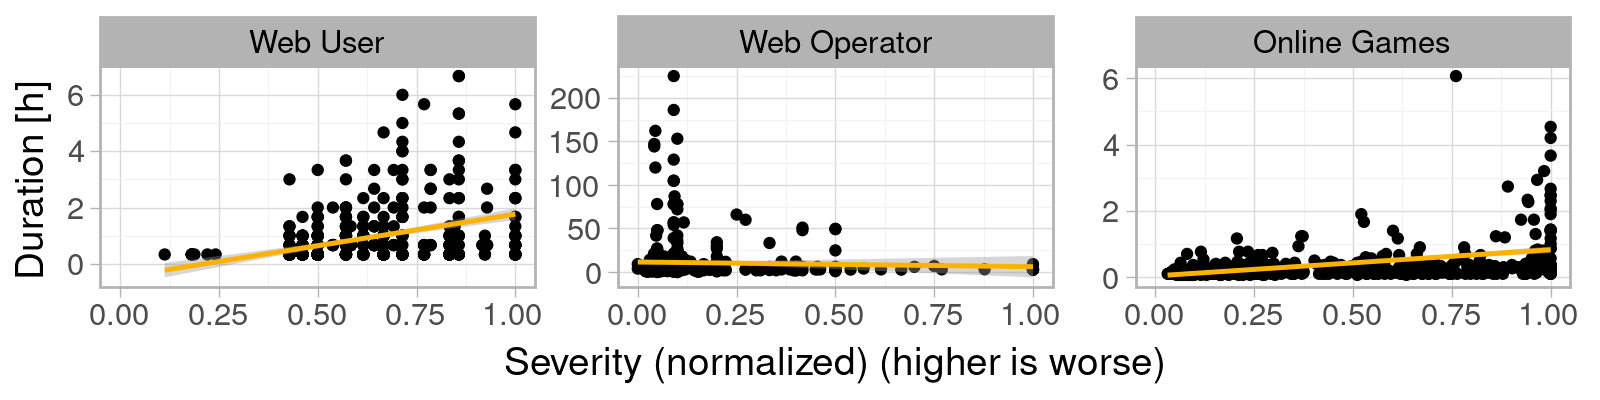

In [117]:
def exponential_labels(inp):
    print(inp)
    exponent = np.log10(inp, where=(np.array(inp) != 0)).astype(int)
    decimal = inp / np.power(10, exponent)
    return [f"${num[0]}\\times10^{num[1]}$" if num[1] != 0 else "1" for num in zip(decimal, exponent)]

plt = (
    ggplot(filtered_df)
    + theme_light(base_size=14)
    + geom_point(aes(x="status", y="duration"))
    + geom_smooth(aes(x="status", y="duration"), method="lm", color="#FFB200")
    + xlab("Severity (normalized) (higher is worse)")
    + ylab("Duration [h]")
    + scale_y_continuous()
    + facet_wrap("name", scales="free_y")
    + theme(figure_size=[8,2], strip_text=element_text(color="black"))
)

plt.save("plots_pdf/duration_severity_correlation.pdf")
plt

/home/stalluri/.miniconda3/envs/thesis/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 3 in image.
/home/stalluri/.miniconda3/envs/thesis/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots_pdf/severity_ecdf.pdf


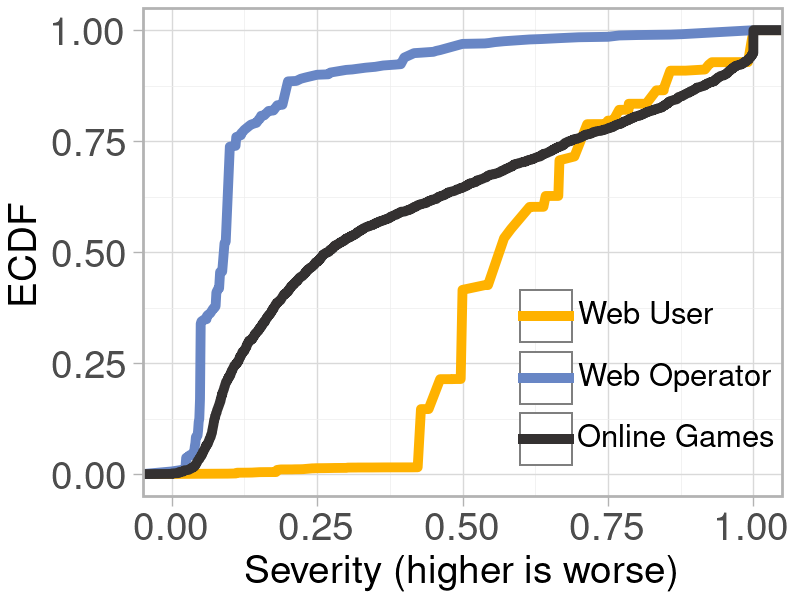

In [121]:
plt = (
    ggplot(all_df)
    + theme_light(base_size=14)
    + geom_line(aes(x="status", group="name", color="name"), stat=stat_ecdf, size=2)
    + scale_color_manual(["#FFB200","#6886c5","#343131"])
    + xlab("Severity (higher is worse)")
    + ylab("ECDF")
    + guides(color=guide_legend(title=""))
    + theme(figure_size=[4,3], axis_text=element_text(size=14), legend_position=(0.99, 0.1),
           legend_background=element_rect(fill=(0,0,0,0)))
)

plt.save("plots_pdf/severity_ecdf.pdf")
plt